In [ ]:
# Load dependencies
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.cuda as cutorch
import timeit
import scipy.special
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
torch.cuda.max_memory_allocated()

In [ ]:
# Helper functions
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [ ]:
# Dataloader with paths
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# Determine the bias using validation set

In [6]:
# Set global properties
num_classes=2
input_size=224
batch_size=8
flavor=18
data_dir = "/home/pyushkevich/data/twoway"

In [8]:
# Read the model
if flavor == 50:
    model_ft = models.resnet50(pretrained=False)
    model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)
    model_ft.load_state_dict(torch.load('my_resnet_50_200epoch.dat'))
else:
    model_ft = models.resnet18(pretrained=False)
    model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)
    model_ft.load_state_dict(torch.load('my_resnet_200epoch.dat'))
    
model_ft.eval()

# Send model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Sending loaded model to device: ", device)
model_ft = model_ft.to(device)

Sending loaded model to device:  cuda:0


In [9]:
# Create a data loader
dt_val = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

ds_val = ImageFolderWithPaths(os.path.join(data_dir, "val"), dt_val)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=batch_size, shuffle=True, num_workers=4)

In [10]:
# Compute the ROC curve for the validation set to determine the best bias
roc_y = np.empty(0)
roc_ypred = np.empty(0)
for img,label,paths in dl_val:
    img_d = img.to(device)
    roc_y=np.append(roc_y, label.numpy())
    outputs = model_ft(img_d)
    roc_ypred=np.append(roc_ypred,outputs[:,1].detach().cpu().numpy() - outputs[:,0].detach().cpu().numpy())


In [11]:
from sklearn.metrics import roc_curve
fpr,tpr,thresh = roc_curve(roc_y, roc_ypred)

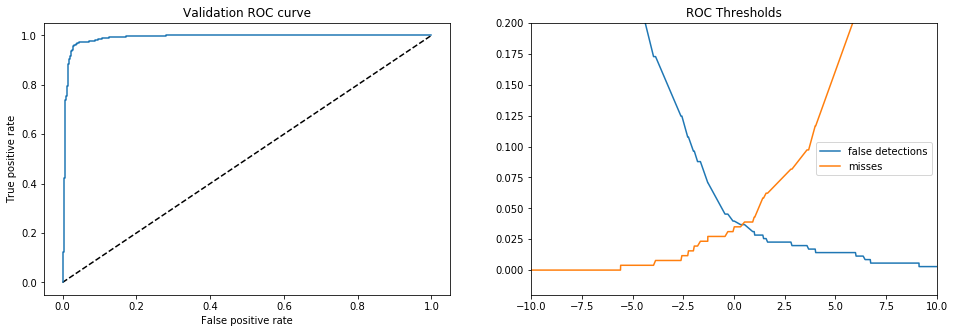

In [12]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot([0, 1], [0, 1], 'k--');
plt.plot(fpr,tpr);
plt.xlabel("False positive rate");
plt.ylabel("True positive rate");
plt.title("Validation ROC curve");

plt.subplot(122)
plt.plot(thresh,fpr,label="false detections");
plt.plot(thresh,1-tpr,label="misses");
plt.legend(loc='best')
plt.ylim(-0.02, 0.2)
plt.xlim(-10,10)
plt.title("ROC Thresholds");

In [13]:
# Validation function
# Perform full test set evaluation and save examples of errors
def full_set_eval(model, data_loader, bias=0.):
    cm=np.zeros((num_classes,num_classes))
    img_fp = torch.empty(0)
    img_fn = torch.empty(0)
    path_fp = []
    path_fn = []
    for img,label,paths in data_loader:
        img_d = img.to(device)
        label_d = label.to(device)
        outputs = model(img_d)
        outputs[:,0] += bias; outputs[:,1] -= bias;
        _, preds = torch.max(outputs, 1)
        for a in range(0,len(label)):
            l_pred = preds.cpu()[a].item()
            l_true = label[a].item()
            cm[l_pred,l_true]=cm[l_pred,l_true]+1
            if l_pred == 1 and l_true == 0:
                # False positive (non-tangle classified as tangle)
                img_fp = torch.cat((img_fp, img_d[a:a+1,:,:,:].cpu()))
                path_fp.append(paths[a]) 
            elif l_pred == 0 and l_true == 1:
                # False negative (tangle classified as non-tangle)
                img_fn = torch.cat((img_fn, img_d[a:a+1,:,:,:].cpu()))
                path_fn.append(paths[a]) 
    return cm


In [14]:
cm_val = full_set_eval(model_ft, dl_val, 0.0)
cm_val

array([[339.,   9.],
       [ 14., 248.]])

In [15]:
print("False positive rate: ", cm_val[1,0] / (cm_val[1,0] + cm_val[0,0]))
print("False negative rate: ", cm_val[0,1] / (cm_val[0,1] + cm_val[1,1]))

False positive rate:  0.039660056657223795
False negative rate:  0.03501945525291829


# Validate on the test set

In [17]:
# Create a data loader
dt = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

ds = ImageFolderWithPaths(os.path.join(data_dir, "test"), dt)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4)

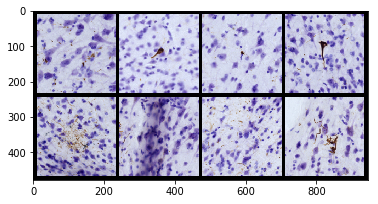

In [18]:
# Read a batch of data
img,label,paths=next(iter(dl))
show(torchvision.utils.make_grid(img, padding=10, nrow=4, normalize=True))

In [19]:
# Evaluate model on this batch
model_ft.eval()
img_d = img.to(device)
label_d = label.to(device)
outputs = model_ft(img_d)
_, preds = torch.max(outputs, 1)
(preds.cpu(),label)


(tensor([0, 1, 1, 1, 0, 0, 0, 1]), tensor([0, 1, 1, 1, 0, 0, 0, 0]))

In [20]:
# Perform full test set evaluation and save examples of errors
cm=np.zeros((num_classes,num_classes))
img_fp = torch.empty(0)
img_fn = torch.empty(0)
path_fp = []
path_fn = []
for img,label,paths in dl:
    img_d = img.to(device)
    label_d = label.to(device)
    outputs = model_ft(img_d)
    _, preds = torch.max(outputs, 1)
    for a in range(0,len(label)):
        l_pred = preds.cpu()[a].item()
        l_true = label[a].item()
        cm[l_pred,l_true]=cm[l_pred,l_true]+1
        if l_pred == 1 and l_true == 0:
            # False positive (non-tangle classified as tangle)
            img_fp = torch.cat((img_fp, img_d[a:a+1,:,:,:].cpu()))
            path_fp.append(paths[a]) 
        elif l_pred == 0 and l_true == 1:
            # False negative (tangle classified as non-tangle)
            img_fn = torch.cat((img_fn, img_d[a:a+1,:,:,:].cpu()))
            path_fn.append(paths[a]) 

cm

array([[326.,   8.],
       [ 24., 251.]])

In [21]:
(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])

0.9474548440065681

['/home/pyushkevich/data/data/ambiguous/1670.png',
 '/home/pyushkevich/data/data/artifact/2240.png',
 '/home/pyushkevich/data/data/threads/660.png',
 '/home/pyushkevich/data/data/ambiguous/2051.png',
 '/home/pyushkevich/data/data/threads/900.png',
 '/home/pyushkevich/data/data/astrocyte_tau/2780.png',
 '/home/pyushkevich/data/data/astrocyte_tau/591.png',
 '/home/pyushkevich/data/data/dirt/991.png',
 '/home/pyushkevich/data/data/threads/1740.png',
 '/home/pyushkevich/data/data/threads/2621.png',
 '/home/pyushkevich/data/data/threads/1500.png',
 '/home/pyushkevich/data/data/threads/951.png',
 '/home/pyushkevich/data/data/astrocyte_tau/2641.png',
 '/home/pyushkevich/data/data/astrocyte_tau/1761.png',
 '/home/pyushkevich/data/data/astrocyte_tau/2790.png',
 '/home/pyushkevich/data/data/ambiguous/540.png',
 '/home/pyushkevich/data/data/astrocyte_tau/2640.png',
 '/home/pyushkevich/data/data/artifact/1540.png',
 '/home/pyushkevich/data/data/tissue/921.png',
 '/home/pyushkevich/data/data/thread

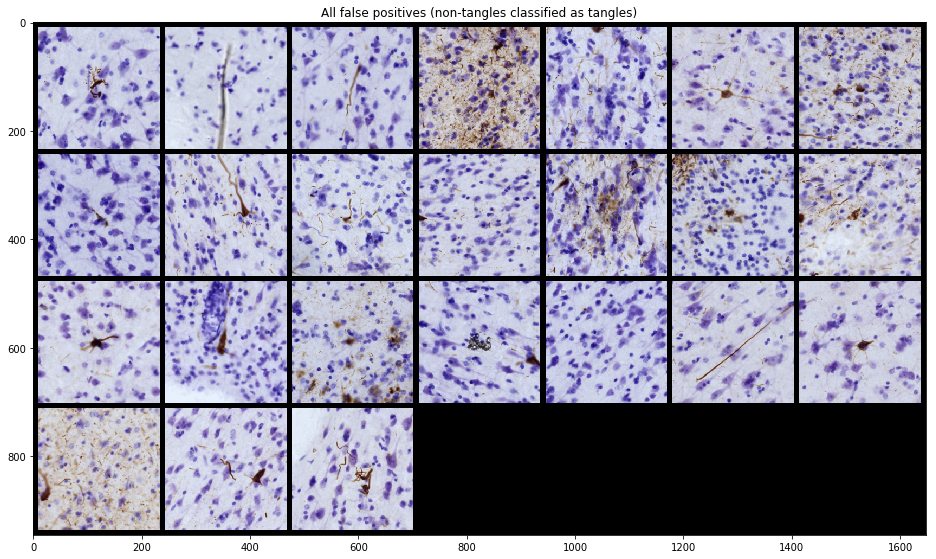

In [22]:
# Plot the false positives
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img_fp, padding=10, nrow=7, normalize=True))
plt.title("All false positives (non-tangles classified as tangles)");
list(map(os.path.realpath, path_fp))

['/home/pyushkevich/data/data/tangle/2970.png',
 '/home/pyushkevich/data/data/tangle/1981.png',
 '/home/pyushkevich/data/data/tangle/2971.png',
 '/home/pyushkevich/data/data/tangle/2160.png',
 '/home/pyushkevich/data/data/tangle/2930.png',
 '/home/pyushkevich/data/data/tangle/2911.png',
 '/home/pyushkevich/data/data/tangle/2910.png',
 '/home/pyushkevich/data/data/tangle/2681.png']

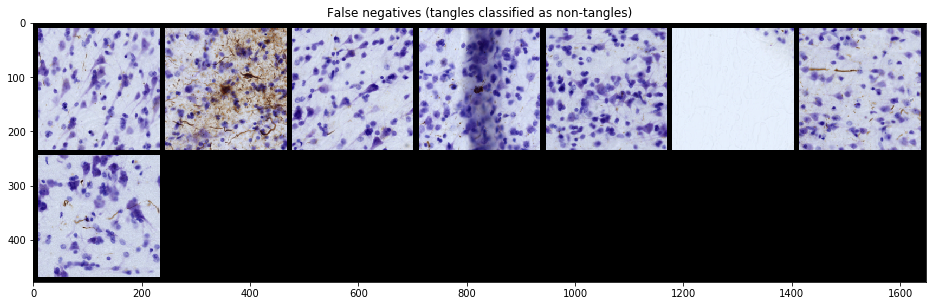

In [23]:
# Plot the false negatives
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img_fn, padding=10, nrow=7, normalize=True))
plt.title("False negatives (tangles classified as non-tangles)");
list(map(os.path.realpath, path_fn))

# Direct Classification of OpenSlide Images

In [24]:
import openslide

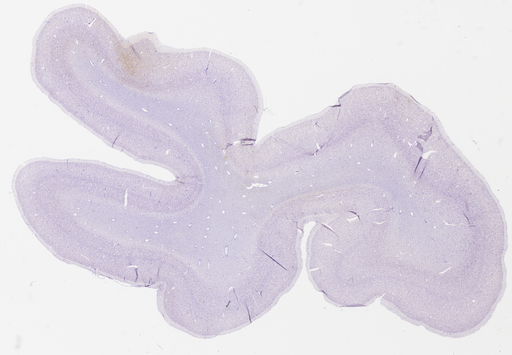

In [25]:
# Read a slide and show thumbnail
osl=openslide.OpenSlide('/home/pyushkevich/285342.svs')
osl.get_thumbnail((512,512))

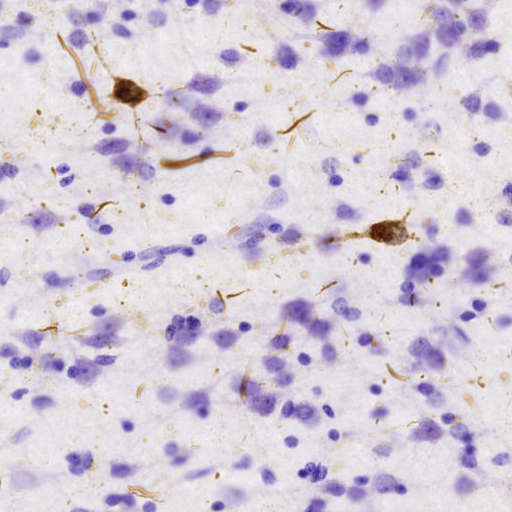

In [26]:
# Pull out a little region of the image
osl.read_region((40350,20300),0,(512,512))

In [37]:
# Strides in pixels
stride=100

# Window size in strides
window_size=4

# Strides per chunk
chunk_size=40

# Determine the actual width of the image needed for this chunk
chunk_width=stride*(chunk_size+window_size-1)
print("Chunk width: ", chunk_width)

# Determine the dimensions of the output image
out_dim=(np.array(osl.dimensions)/stride - window_size + 1).astype(int)
out_pnt=np.zeros(out_dim)
out_ptg=np.zeros(out_dim)

# Transformed stride and width
stride_t = int(input_size / window_size)

# Start at some position
# u_0 = 200; v_0 = 200;
# u_1 = 290; v_1 = 260;
u_0 = 0; u_1 = out_dim[0];
v_0 = 0; v_1 = out_dim[1];

t_start = timeit.default_timer()

# Keep track of all the chunks that are potential hits
hit_map=np.zeros(out_dim)

# Range over u and v
for u in range(u_0, u_1, chunk_size):
    for v in range(v_0, v_1, chunk_size):
        
        # The actual dimension of the region in steps
        cs_u = min(u_1 - u, chunk_size)
        cs_v = min(v_1 - v, chunk_size)
        
        # Chunk size in pixels - what to read from the image
        csp_u = stride * (cs_u + window_size - 1)
        csp_v = stride * (cs_v + window_size - 1)

        # Read the chunk
        t0 = timeit.default_timer()
        chunk_img=osl.read_region((u*stride, v*stride), 0, (csp_u, csp_v)).convert("RGB")

        t1 = timeit.default_timer()
        
        # Transform the chunk
        chunk_dt = transforms.Compose([
                transforms.Resize(int(stride_t*(min(cs_u, cs_v)+window_size-1))),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        
        chunk_tensor=chunk_dt(chunk_img).to(device)
        chunk_ufold=chunk_tensor.unfold(1,input_size,stride_t).unfold(2,input_size,stride_t).permute((1,2,0,3,4))

        # Process batches
        t2 = timeit.default_timer()

        for i in range(0,cs_u):
            with torch.no_grad():
                y_i = model_ft(chunk_ufold[:,i,:,:,:]).cpu().detach().numpy()
            for j in range(0,cs_v):
                out_pnt[u+i:u+i+window_size,v+j:v+j+window_size] += y_i[j,0]
                out_ptg[u+i:u+i+window_size,v+j:v+j+window_size] += y_i[j,1]
                hit_map[u+i,v+j] = np.argmax(y_i[j,:])
            
        t3 = timeit.default_timer()
        
        # Report
        print("Completed chunk (%d,%d), t_read=%8.4f  t_ufld=%8.4f  t_cnn=%8.4f  t=%8.4f" %
              (u, v, t1-t0, t2-t1, t3-t2, t3-t0))

t_end = timeit.default_timer()
print("Total time elapsed: ", t_end - t_start)

Chunk width:  4300
Completed chunk (0,0), t_read=  0.8641  t_ufld=  0.3743  t_cnn=  1.0456  t=  2.2840
Completed chunk (0,40), t_read=  0.9327  t_ufld=  0.3544  t_cnn=  1.0384  t=  2.3256
Completed chunk (0,80), t_read=  0.9259  t_ufld=  0.3689  t_cnn=  1.0385  t=  2.3332
Completed chunk (0,120), t_read=  0.9343  t_ufld=  0.3423  t_cnn=  1.0374  t=  2.3140
Completed chunk (0,160), t_read=  0.9142  t_ufld=  0.3700  t_cnn=  1.0368  t=  2.3210
Completed chunk (0,200), t_read=  0.9402  t_ufld=  0.3462  t_cnn=  1.0377  t=  2.3241
Completed chunk (0,240), t_read=  0.9619  t_ufld=  0.3977  t_cnn=  1.0378  t=  2.3974
Completed chunk (0,280), t_read=  1.1841  t_ufld=  0.3740  t_cnn=  1.0391  t=  2.5972
Completed chunk (0,320), t_read=  1.0675  t_ufld=  0.3983  t_cnn=  1.0387  t=  2.5046
Completed chunk (0,360), t_read=  1.0880  t_ufld=  0.3734  t_cnn=  1.0402  t=  2.5016
Completed chunk (0,400), t_read=  1.0668  t_ufld=  0.3677  t_cnn=  1.0367  t=  2.4713
Completed chunk (0,440), t_read=  0.990

In [38]:
# A function to plot a region of the histology image and corresponding tangle prediction
def plot_classification_region(u0,v0,u1,v1,d_sample):
    # The image region
    img_rgn=osl.read_region((u0*stride,v0*stride), d_sample,
                            (int((u1-u0)*stride/osl.level_downsamples[d_sample]),
                             int((v1-v0)*stride/osl.level_downsamples[d_sample])))
    
    # The tangle map
    t_map=out_ptg[u0:u1,v0:v1].transpose()-out_pnt[u0:u1,v0:v1].transpose()
    
    # Create plots side by side
    fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
    
    # Plot the image region
    ax[0].imshow(img_rgn, extent=(u0,u1,v1,v0))
    cs=ax[1].imshow(t_map, plt.get_cmap("jet"), vmin=-500, vmax=500, extent=(u0,u1,v1,v0))
    # ax[1].colorbar(cs)
    fig.show()

#os.level_downsamples
#os.read_region((u_0*stride,v_0*stride),1,(int((u_1-u_0)*stride/os.level_downsamples[1]),int((v_1-v_0)*stride/os.level_downsamples[1])))

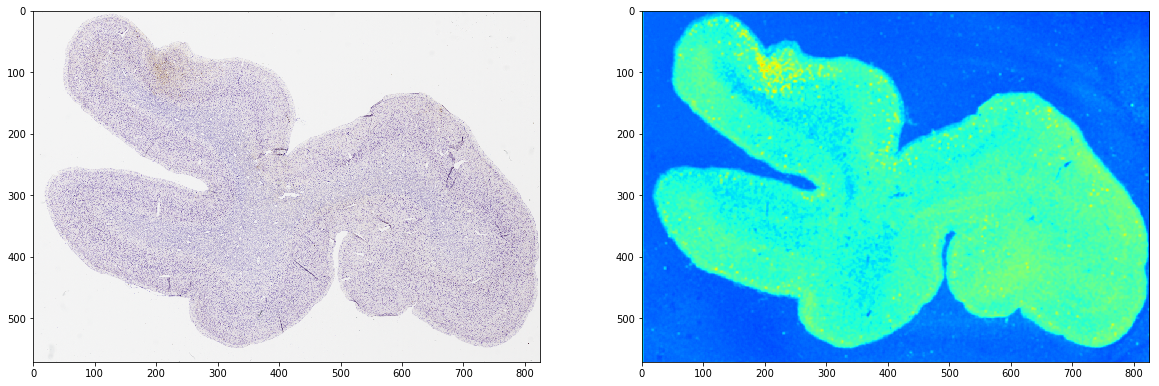

In [39]:
# Plot the entire extent of the slide
plot_classification_region(0,0,out_dim[0],out_dim[1],3)

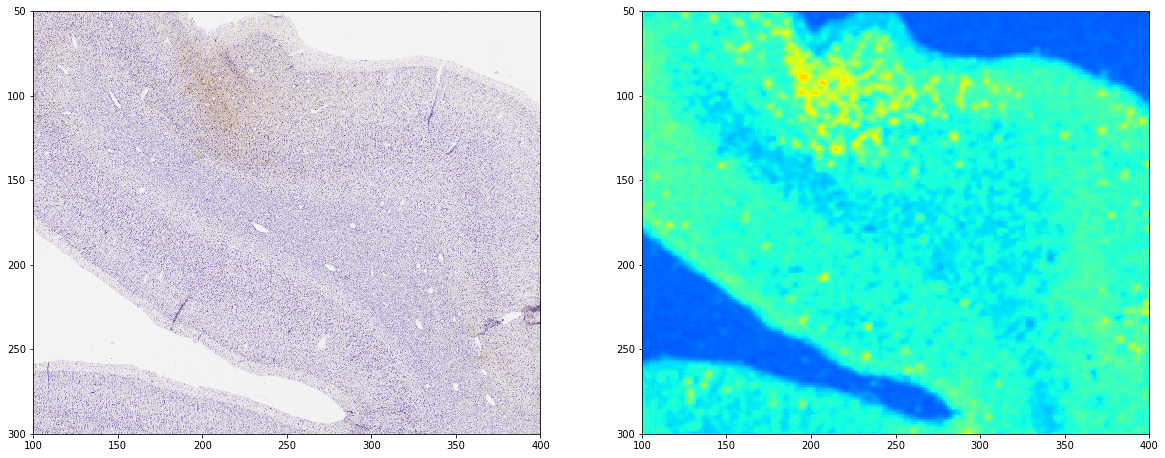

In [40]:
plot_classification_region(100,50,400,300,2)

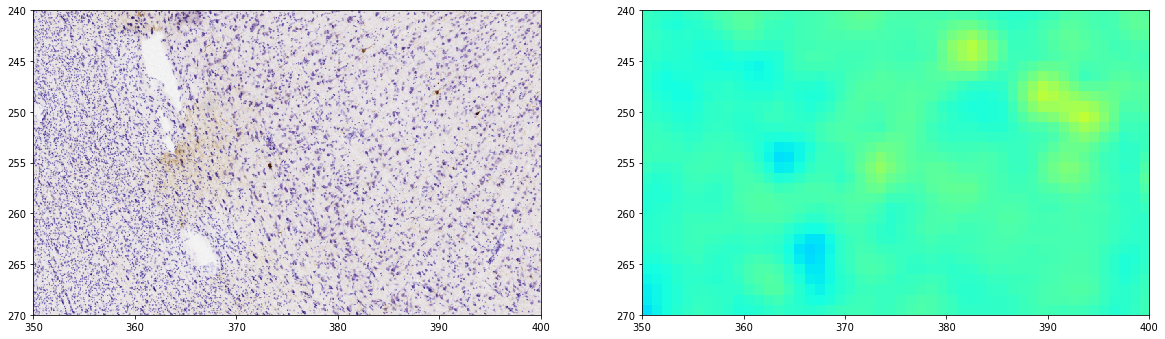

In [41]:
plot_classification_region(350,240,400,270,1)

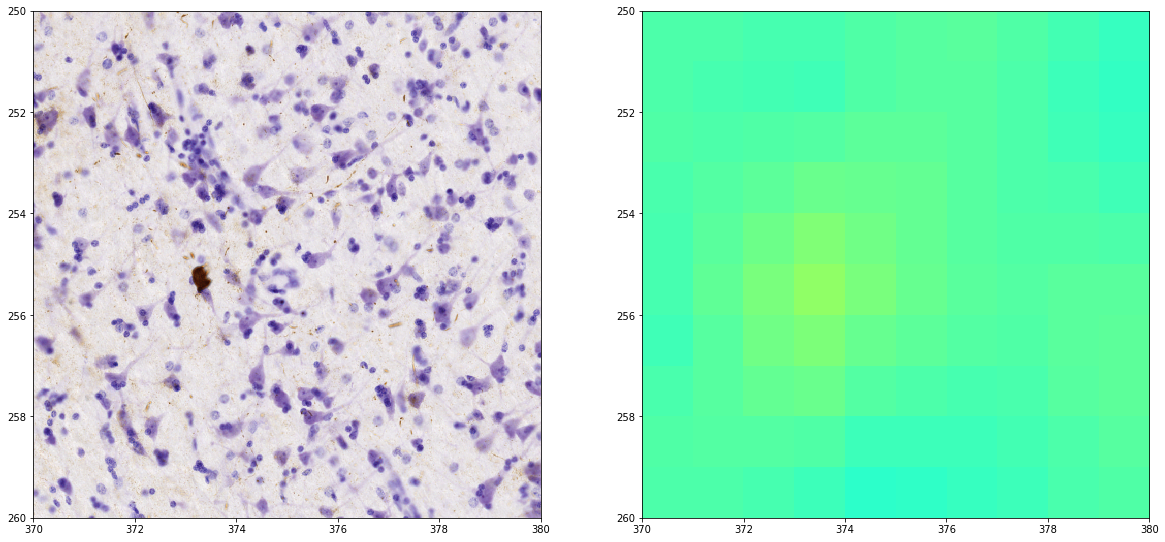

In [42]:
plot_classification_region(370,250,380,260,0)

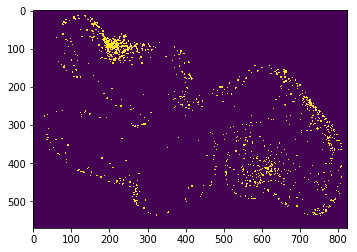

In [47]:
# Look at and save the hit map
plt.imshow(hit_map.transpose())
np.save("my_resnet_18_hitmap.npy", hit_map)